In [41]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
import SimpleITK as sitk

Patient ID: NOID
Modality: CT
Image Shape: (512, 512)


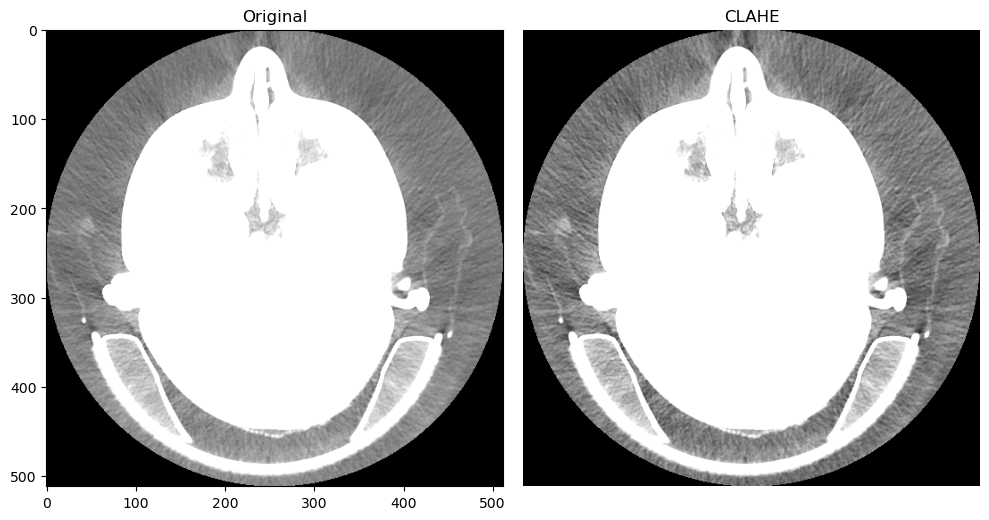

In [39]:

# Path to DICOM folder
dicom_dir = "C:/Users/shani/Downloads/2_skull_ct/DICOM"

# Load one DICOM file
filename = os.listdir(dicom_dir)[240]
dcm = pydicom.dcmread(os.path.join(dicom_dir, filename))

# 1. Inspect metadata
print("Patient ID:", dcm.PatientID)
print("Modality:", dcm.Modality)
print("Image Shape:", dcm.pixel_array.shape)

# 2. Convert to image
img = dcm.pixel_array.astype(np.float32)

# 3. Rescale using Window Center/Width (if available)
if 'WindowCenter' in dcm and 'WindowWidth' in dcm:
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    img = np.clip(img, center - width//2, center + width//2)
else:
    img = np.clip(img, np.percentile(img, 1), np.percentile(img, 99))

# Normalize to 0–255
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# 4. Apply CLAHE (contrast enhancement)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img_norm)

# 5. Display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_norm, cmap='gray'); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_clahe, cmap='gray'); plt.title('CLAHE')
plt.axis('off') 
plt.tight_layout()
plt.show()


Found series: ('1.3.6.1.4.1.5962.99.1.1761388472.1291962045.1616669124536.2593.0', '1.3.6.1.4.1.5962.99.1.1761388472.1291962045.1616669124536.2599.0', '1.3.6.1.4.1.5962.99.1.1761388472.1291962045.1616669124536.2634.0', '1.3.6.1.4.1.5962.99.1.1761388472.1291962045.1616669124536.2702.0', '1.3.6.1.4.1.5962.99.1.1761388472.1291962045.1616669124536.2814.0')
Volume shape (z,y,x): (2, 367, 835)
Spacing (x,y,z): (0.634731, 0.545455, 374.7665940288702)
Origin: (-265.0, 0.0, 150.0)
Direction: (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0)


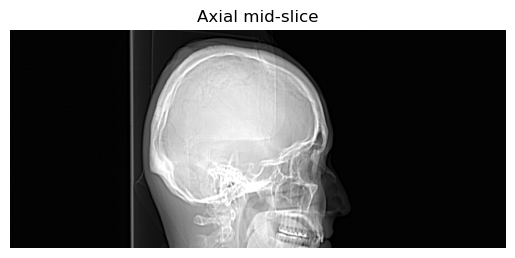

In [55]:
dicom_dir = "C:/Users/shani/Downloads/2_skull_ct/DICOM"

# 1) Find series in the folder (some folders contain multiple series)
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(dicom_dir)
print("Found series:", series_ids)
assert series_ids, "No DICOM series found."

# pick the first (or let the user choose)
series_files = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(dicom_dir, series_ids[0])

# 2) Read the series into a 3D image
reader = sitk.ImageSeriesReader()
reader.SetFileNames(series_files)
img3d = reader.Execute()                  # SimpleITK image

# 3) Convert to NumPy volume (z, y, x)
vol = sitk.GetArrayFromImage(img3d)       # shape: (num_slices, height, width)
spacing = img3d.GetSpacing()              # (sx, sy, sz) in mm (note order!)
origin  = img3d.GetOrigin()
direction = img3d.GetDirection()
print("Volume shape (z,y,x):", vol.shape)
print("Spacing (x,y,z):", spacing)
print("Origin:", origin)
print("Direction:", direction)

# 4) Quick windowing to visualize (percentile clip -> 0..255 uint8)
mid = vol.shape[0] // 2
slice_img = vol[mid].astype(np.float32)
lo, hi = np.percentile(slice_img, (1, 99))
slice_img = np.clip(slice_img, lo, hi)
slice_img = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.imshow(slice_img, cmap='gray'); plt.title("Axial mid-slice"); plt.axis('off'); plt.show()